In [1]:
import numpy as np
import os

np.random.seed(42)

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

PROJECT_ROOT_DIR = "."
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images")
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)



In [2]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [124]:
# EXTRA
import math
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    n_rows = math.ceil(len(instances) / images_per_row)
    # n_rows = (len(instances) - 1) // images_per_row + 1

    # Append empty images to fill the end of the grid, if needed:
    n_empty = n_rows * images_per_row - len(instances)
    padded_instances = np.concatenate([instances, np.zeros((n_empty, size * size))], axis=0)

    # Reshape the array so it's organized as a grid containing 28×28 images:
    image_grid = padded_instances.reshape((n_rows, images_per_row, size, size))

    # Combine axes 0 and 2 (vertical image grid axis, and vertical image axis),
    # and axes 1 and 3 (horizontal axes). We first need to move the axes that we
    # want to combine next to each other, using transpose(), and only then we
    # can reshape:
    big_image = image_grid.transpose(0, 2, 1, 3).reshape(n_rows * size,
                                                         images_per_row * size)
    # Now that we have a big image, we just need to show it:
    plt.imshow(big_image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

In [6]:
X, y = mnist["data"], mnist["target"]

In [7]:
X.shape

(70000, 784)

In [8]:
y.shape

(70000,)

There are 70,000 images and each image has (784 features) 

784 features = 28 x 28 pixels. (each pixel represents a intensity from 0 (white) to 255 (black)

In [11]:
some_digit = X[0]
some_digit_image = some_digit.reshape(28,28)

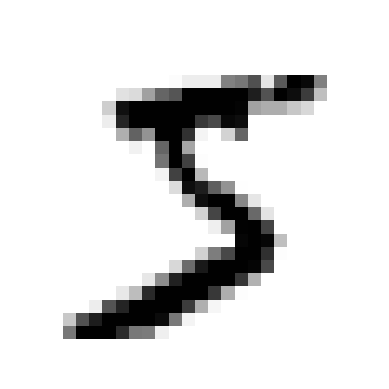

In [12]:
plt.imshow(some_digit_image, cmap="binary")
plt.axis("off")
plt.show()

In [13]:
y[0]

'5'

the label has '5' as string. ML algorithms like numbers so we will cast y to integer

In [14]:
y = y.astype(np.uint8)

MNIST data is already split into a training set (first 60,000 images) and a test set (last 10,000 images)

In [15]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000],y[60000:]

## Training a Binary Classifier

We will only try to identify 1 digit for now. This "5-detector" will be a binary calssifier

In [16]:
y_train_5 = (y_train==5)
y_test_5 = (y_test==5)

We will choose *Stochastic Gradient Descent (SGD)* classifier `SGDClassifier` class

This has the advantage of being capable of handling large datasets efficiently.

-sgd also has advantage of dealing with training instances independently, one at a time (this makes SGD good for online learning)

In [17]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(max_iter=1000, tol=1e-3, random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [18]:
sgd_clf.predict([some_digit])

array([ True])

It was able to predict that the given digit '5' was indeed 5!

## Performance measure

Evaluating a classifier is more trickier than evaluating a regressor

### Measuring Accuracy Using Cross-Validation

Great to measure a model performance is through **Cross-validation**

In [20]:
from sklearn.model_selection import cross_val_score
cross_val_score(estimator=sgd_clf, X=X_train, y=y_train_5,cv=3, scoring='accuracy')

array([0.95035, 0.96035, 0.9604 ])

In [25]:
y_train

array([5, 0, 4, ..., 5, 6, 8], dtype=uint8)

In [28]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, shuffle=True,random_state=42)

for train_index, test_index in skfolds.split(X_train,y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]

    clone_clf.fit(X_train_folds,y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred==y_test_fold)
    print(n_correct/len(y_pred))

0.9669
0.91625
0.96785


Although the accuracy comes out to over 90% accuracy, remember... This is simply because **only about 10% of the images are 5s** so if you always guess that an image is not a 5, you will be right about 90% of the time

In [29]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self,X):
        return np.zeros((len(X), 1), dtype=bool)
        

In [32]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.91125, 0.90855, 0.90915])

See? this also returns 90% above because only about 10% images are 5s

This shows why accuracy is generally not the preferred perofrmance measure for classifiers, especially when you are dealing with *skewed data*

## Confusion Matrix

For classifier, use *confusion Matrix*

General idea is to *count the number of times intances of class A are classfied as class B.*

i.e. how many times model confused number 5 and 3. we would look at fifth row and third column

To do confusion matrix we need:

- set of predictions so that they can be compared to the actual targets


In [33]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

just like `cross_val_score()` function, `cross_val_predict()` performs k-fold cross-validation but instead of returning evaluation scores, it retuns the predictions made on each test fold. so we get clean prediction for each instance in the training set

In [34]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_pred) #target class = y_train_5 and predicted class = y_train_pred

array([[53892,   687],
       [ 1891,  3530]])

Each row in confusion matrix represents an *actual class*, while each column represents a *predicted* class. 

The first row of this matrix considers non-5 images (*negative class*). 53892 of them were correctly classified as non-5s (*true negative*)

While remaining 687 were wrongly classified as 6s (*false positives*)

Second row considers the images of 5s (*positive class*). 1891 were wrongly classified as non-5s (*false negatives*)

while remainin 3530 were correctly classified as 5s (*true positives*)

TN|FP

FN|TP

## Precision vs Recall

TP is the number of True Positive. FP is the number of False Positive

$$
precision = \frac{TP}{TP+FP}
$$
Precision is the accuracy of the positive predictions

$$
recall = \frac{TP}{TP+FN}
$$
Recall is also known as *sensitivity* or *true positive rate (TPR)*

In [37]:
from sklearn.metrics import precision_score, recall_score

precision_score(y_train_5, y_train_pred)


0.8370879772350012

In [38]:
cm = confusion_matrix(y_train_5, y_train_pred)
cm[1,1] / (cm[1,1]+cm[0,1])

0.8370879772350012

In [39]:
recall_score(y_train_5, y_train_pred)

0.6511713705958311

In [40]:
cm[1,1]/(cm[1,0]+cm[1,1])

0.6511713705958311

5-detector doesn't look as shiny as it did when you looked at its accuracy. When it claimed the image represents a 5, it is correct only 83.7% of the time. Moreover, it only detects 65.12% of the 5s. 

It is often conveninent to combine *recall* and *precision* together to get a **F1** score.

F1 score is a *harmonic mean* of the precision and recall. Harmonic mean gives much more weight to low values (whereas regular mean treats all values equally)

$$
F_1 = \frac{2}{\frac{1}{precision}+\frac{1}{recall}}= 2 \times \frac{precision \times recall}{precision + recall} = \frac{TP}{TP+\frac{FN+FP}{2}}
$$

In some cases, you want high precision, low recall (i.e. you want to detect videos that is safe for kids. you would want high precision and low recall. it will reject many good videos (low recall) but it will keep only safe ones (high precision). Another example is classifier to detect shoplifters in surveillance images. It is okay to have low precision as long as it has 99% recall. (security guards may get few false alerts, but almost all shoplifters will get caught)

It is import tnat you can't have both ways: *increasing precision reduces recall, and vice versa*

This is known as *precision/recall trade off*

In [41]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7325171197343847

## Precision / Recall Trade-off

`SGDClassifier` makes its classification decision. For each instance, it computes a score based on a *decision function*. If the score is greater than a threshold, it assings the instance to the positive class; vice versa.

Scikit-Learn does not let you set the threshold directly, but it does give you access to the decision scores that it uses to make predictions. Instead of calling classifier's `predict()` method, we can use `decision_function()` which returns a score for each instance, and then use any threshold you want to make predicions based on those scores

In [42]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

In [43]:
threshold = 0
y_some_digit_prediction = (y_scores > threshold)
y_some_digit_prediction

array([ True])

In [44]:
threshold = 8000
y_some_digit_prediction = (y_scores > threshold)
y_some_digit_prediction

array([False])

How to decide which threshold to use?

1. use `cross_val_predict()` function to get the scores of all instances in the training set (specify decision_function)
2. With these scores, use the `precision_recall_curve()` function to compute precision and recall for all possible threshold

In [62]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method = "decision_function")

In [63]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

In [64]:
def plot_precision_recall_vs_threshold(precisions, recalls, threshold):
    plt.plot(thresholds, precision[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label = "Recall", linewidth=2)
    plt.legend(loc="center right", fontsize=16)
    plt.xlabel("Threshold", fontsize=16)
    plt.grid(True)
    plt.axis([-50000, 50000, 0, 1])

Saving figure precision_recall_vs_threshold_plot


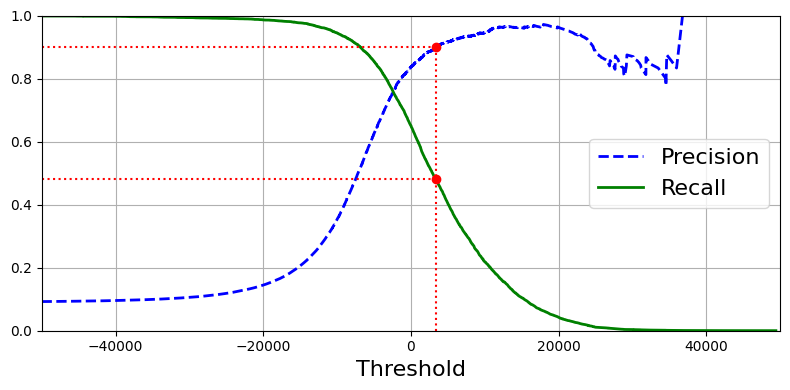

In [65]:
recall_90_precision = recalls[np.argmax(precisions >= 0.90)]
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]


plt.figure(figsize=(8, 4))                               
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.plot([threshold_90_precision, threshold_90_precision], [0., 0.9], "r:")                 
plt.plot([-50000, threshold_90_precision], [0.9, 0.9], "r:")                               
plt.plot([-50000, threshold_90_precision], [recall_90_precision, recall_90_precision], "r:")
plt.plot([threshold_90_precision], [0.9], "ro")                                            
plt.plot([threshold_90_precision], [recall_90_precision], "ro")                             
save_fig("precision_recall_vs_threshold_plot")                                             
plt.show()

In [66]:
(y_train_pred == (y_scores > 0)).all()

True

Saving figure precision_vs_recall_plot


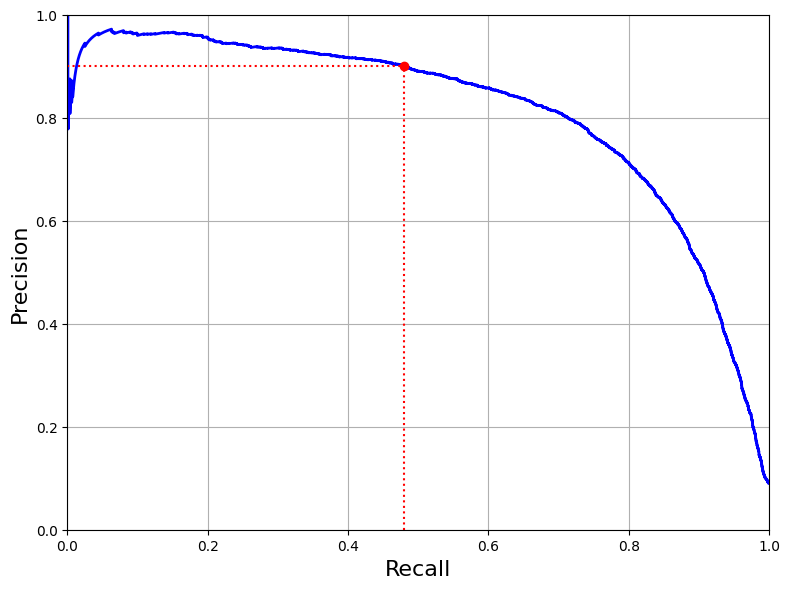

In [67]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])
    plt.grid(True)

plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
plt.plot([recall_90_precision, recall_90_precision], [0., 0.9], "r:")
plt.plot([0.0, recall_90_precision], [0.9, 0.9], "r:")
plt.plot([recall_90_precision], [0.9], "ro")
save_fig("precision_vs_recall_plot")
plt.show()

another way to select a good precision/recall trade off is to plot precision directly against recall.

As you can see, precision really starts to fall sharply around 80% recall. so we want t o select a precision/recall trade off just before that drop

How can we find the threshold that will give us 90% precision?

by using np.argmax() we can get lowest threshold that gives at least 90% precision

In [68]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]

In [71]:
threshold_90_precision

3370.019499144183

In [69]:
y_train_pred_90 = (y_scores >= threshold_90_precision)

In [70]:
precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

In [72]:
recall_score(y_train_5, y_train_pred_90)

0.4799852425751706

high precision at 90% but recall is below 50% which isnt too good...

## ROC Curve

*Receiver Operating Characteristic (ROC) curve is another common tool used with binary classifiers.

Very similar to precision vs recall but ROC curve plots the *true positive rate (recall)* against *false positive rate* (FPR)

FPR - ratio of negative instances that are incorrectly classified as positive. 

FPR = 1 - TNR (*True negative Rate* ratio of negative instances that are correctly classified as negative.

TNR is also known as *specificity* thus ROC curve plots *sensitivity*(recall) vs 1-*specificity*

TPR VS FPR

In [73]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

Saving figure roc_curve_plot


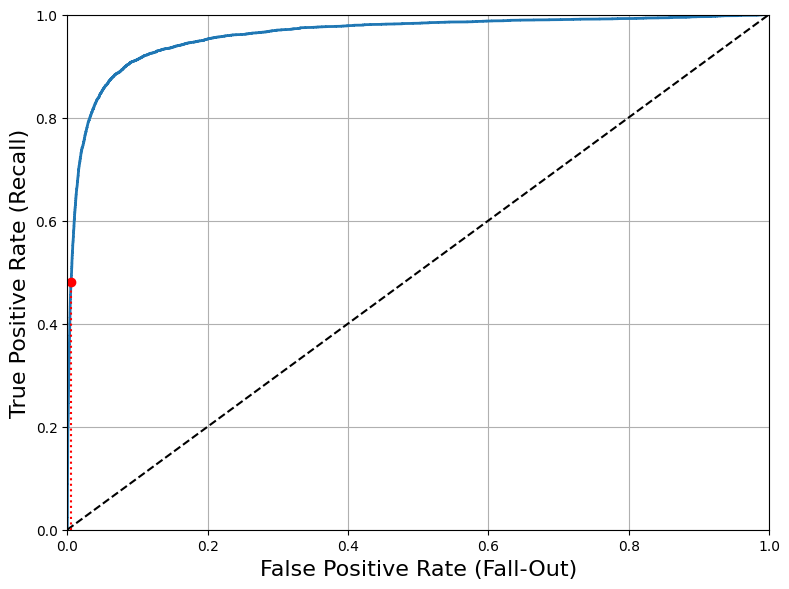

In [76]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
    plt.axis([0, 1, 0, 1])                                    # Not shown in the book
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16) # Not shown
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)    # Not shown
    plt.grid(True)                                            # Not shown

plt.figure(figsize=(8, 6))                                    # Not shown
plot_roc_curve(fpr, tpr)
fpr_90 = fpr[np.argmax(tpr >= recall_90_precision)]           # Not shown
plt.plot([fpr_90, fpr_90], [0., recall_90_precision], "r:")   # Not shown
plt.plot([0.0, fpr_90], [recall_90_precision, recall_90_precision], "r:")  # Not shown
plt.plot([fpr_90], [recall_90_precision], "ro")               # Not shown
save_fig("roc_curve_plot")                                    # Not shown
plt.show()

The higher the Recall (TPR), the more false positives (FPR)

The dotted line represents the ROC curve of a purely random classifier; a good classifier stays as far away from that line as possible (toward the top left corner)

One way to compare classifiers is to measure the AUC (Area under the curve). A perfect classifier will have ROC AUC equal to 1. whereas purely random classifier will have a ROC AUC equal to 0.5

In [77]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9604938554008616

### When should i use ROC over PR (precision recall) curve?

Use PR curve whenever positive class is rare (or when you care more about the false positives than false negatives)

Otherwise, use ROC curve


Now lets train a `RandomForestClassifier` and compare its ROC curve and ROC AUC to that of `SGDClassifier`

However, randomforestClassifier doesmn't have `decision_function()`. instead, it has `predict_proba()` method which returns an arry containing a row per instance and a column per class, each containing the probability that the given instance belongs to the given class

In [79]:
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,
                                    method="predict_proba")

In [82]:
y_probas_forest

array([[0.11, 0.89],
       [0.98, 0.02],
       [0.96, 0.04],
       ...,
       [0.02, 0.98],
       [0.92, 0.08],
       [0.93, 0.07]])

In [84]:
y_scores_forest = y_probas_forest[:,1] # score = probability of positive class
y_scores_forest

array([0.89, 0.02, 0.04, ..., 0.98, 0.08, 0.07])

ROC curve expects labels and scores but instead of scores, we can give it class probabilities

array([ True, False, False, ...,  True, False, False])

In [86]:
fpr_forest, tpr_forest, thresholds_fores = roc_curve(y_train_5, y_scores_forest)

Saving figure roc_curve_comparison_plot


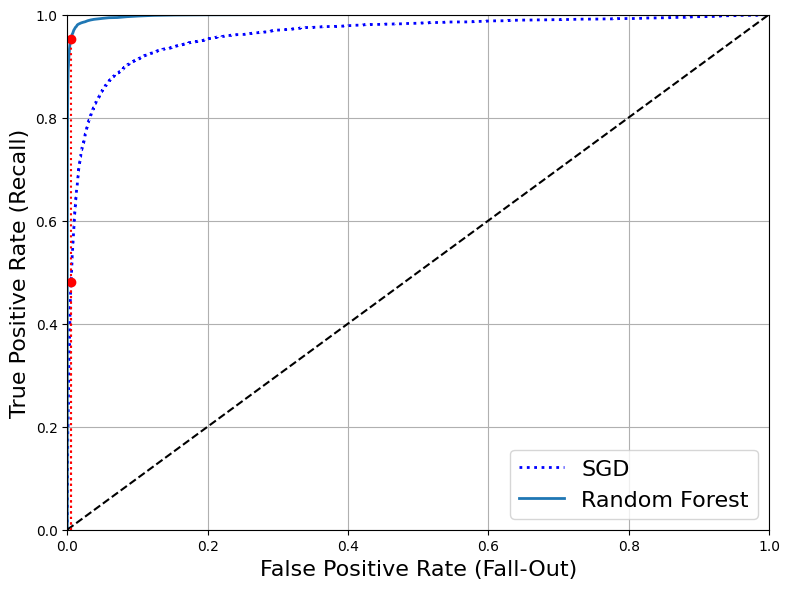

In [87]:
recall_for_forest = tpr_forest[np.argmax(fpr_forest >= fpr_90)]

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, "b:", linewidth=2, label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.plot([fpr_90, fpr_90], [0., recall_90_precision], "r:")
plt.plot([0.0, fpr_90], [recall_90_precision, recall_90_precision], "r:")
plt.plot([fpr_90], [recall_90_precision], "ro")
plt.plot([fpr_90, fpr_90], [0., recall_for_forest], "r:")
plt.plot([fpr_90], [recall_for_forest], "ro")
plt.grid(True)
plt.legend(loc="lower right", fontsize=16)
save_fig("roc_curve_comparison_plot")
plt.show()

We can see that random forest does much better than SGD

In [88]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983296721818179

ROC AUC score is much higher than SGDclassifier

In [89]:
y_train_pred_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3)
precision_score(y_train_5, y_train_pred_forest)

0.9898819561551433

In [90]:
recall_score(y_train_5, y_train_pred_forest)

0.8662608374838591

## Multiclass Classification

SGD classifier, Random Forest Classifiers, and naive Bayes Classifiers are capable of handling multiple classes natively.

Others like Logistic Regression or SVM classifiers are strictly binary classifiers. Although, there are ways to perform multiclass classification using multiple binary classifiers

*One vs all* (or One vs the rest (OVR)) is a system that classify the digit images into 10 classes (0 to 9) and train 10 binary classifiers, one for each digit. Then, when we want to classify an image, we get decision score from each classifier for that image and seelect the class whose classifier outputs the highest score

*one vs one* (OvO) is to train binary classifier for every pair of digits (one to distinguish 0s and 1s, another to distinguish 0s and 2s, another for 1s and 2s ,etc.) Thus, if there are *N* classes, we need to train *N x (N-1)/2* classifiers. For MNIST problem, thats training 45 binary classifiers.

Scikit-learn automatically detects when you try to run binary classification algorithms for a multiclass classification task, and it automatically runs OvR or OvO

In [93]:
# using Support Vector Machine Classifier
from sklearn.svm import SVC

svm_clf = SVC(gamma="auto", random_state=42)
svm_clf.fit(X_train[:1000], y_train[:1000])
svm_clf.predict([some_digit])

# here SVC used OvO as it trained 45 binary classifiers and got their decision scores for each image

array([5], dtype=uint8)

In [94]:
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores

array([[ 2.81585438,  7.09167958,  3.82972099,  0.79365551,  5.8885703 ,
         9.29718395,  1.79862509,  8.10392157, -0.228207  ,  4.83753243]])

In [95]:
np.argmax(some_digit_scores)

5

In [96]:
svm_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [97]:
svm_clf.classes_[5]

5

In [98]:
from sklearn.multiclass import OneVsRestClassifier
ovr_clf = OneVsRestClassifier(SVC(gamma="auto", random_state=42))
ovr_clf.fit(X_train[:1000], y_train[:1000])
ovr_clf.predict([some_digit])

array([5], dtype=uint8)

In [99]:
len(ovr_clf.estimators_) # to check how many estimators (classifiers) were created

10

In [100]:
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array([3], dtype=uint8)

In [101]:
sgd_clf.decision_function([some_digit])

array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

model predicts that the digit is 3 when it is 5. 5 has the negative number but a -1385 while 3 is 1823.

lets see the Cross validation score to evaluate its accuracy

In [102]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.87365, 0.85835, 0.8689 ])

In [103]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([0.8983, 0.891 , 0.9018])

Scaling the inputs allowed it to perform better

## Error Analysis

Let's assume that we've tried with multiple models (shortlisting the best ones and fine-tuning their hyperparameters using GridSearchCV), and automate as much as possible. Here, we will assume that you have found the promising model and we want to find ways to improve it.

We do so by analyzing the types of errors it make

First, lets look at the Confusion Matrix. (first call the `cross_val_predict()` then call `confusion_matrix()`

In [104]:
y_trained_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)

In [109]:
conf_mx = confusion_matrix(y_train, y_trained_pred)

In [110]:
conf_mx

array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]])

In [111]:
def plot_confusion_matrix(matrix):
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    cax = ax.matshow(matrix)
    fig.colorbar(cax)

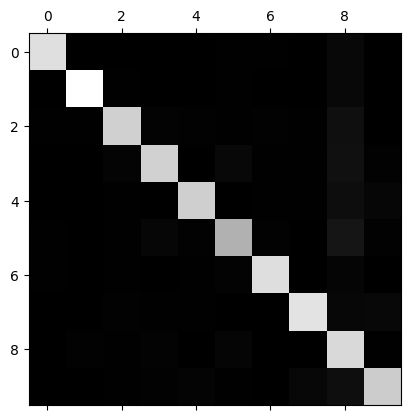

In [112]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

To plot the errors, we need to divide each value in the confusion matrix by the number of images in the corresponding class to compare the error rates instead of absolute numbers of errors

In [114]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

Saving figure confusion_matrix_errors_plot


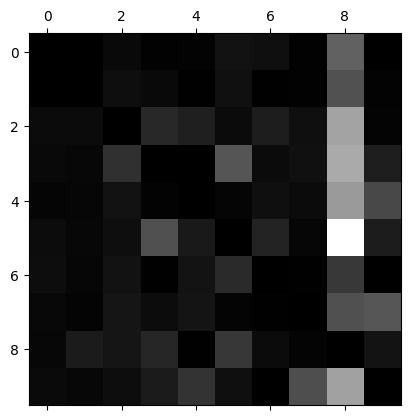

In [115]:
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
save_fig("confusion_matrix_errors_plot", tight_layout=False)
plt.show()

We can see the kinds of errors the classifier makes. 

Row represents actual classes while columns represent predicted classes

column 8 shows bright images showing many images get misclassified as 8s. However, row for 8s is not bad, this shows that actual 8s in general get classified properly.

We can also see that 3 and 5 gets classified wrongly

### insights from confusion matrix

- reduce false 8s
    - gather more data for digits that look like 8s (but are not) so that the classifier can learn to distinguis hthem from real 8s.
-  or engineer new features that would help the classifier (writing algo to count the number of closed loops. 8 has 2, 6 has one, 5 has none)
- preprocess the images (using scikit-image, pillow, or open CV) to make some patterns such as closed loops, stand out more

Analyzing individuals errors can also be a good way to gain insights on what your classifier is doing and why it is failing

i.e. lets plot exanmples of 3s and 5s

ZeroDivisionError: division by zero

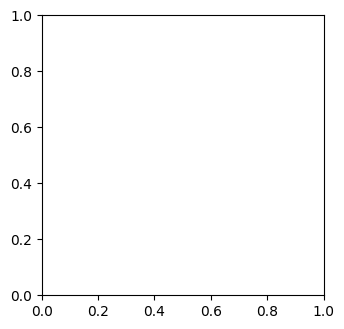

In [125]:
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
save_fig("error_analysis_digits_plot")
plt.show()

# Multilaberl Classification
